# 2. Classifying emotion from call transcripts 

Although using VADER provided the company with a way to see how sentiment changed over the course of each conversation, I thought it would also be useful to have an understanding of specifically which emotions Agents and Borrowers were exhibiting in their conversations. VADER - and most sentiment analysis tools and lexicons - provide sentiment values on a single scale ranging from negative to positive. For the current purposes - identifying good Agent performance, Borrower mood, and potentially aggressive or illegal Agent tactics - having access to a more fine-grained emotion label would be particularly useful.

To this end, I created a coding scheme to capture the different emotions that Borrowers exhibit during their conversations. I labeled these by hand and fed the labels into supervised multinomial models to examine whether a model could be trained to accurately classify turns into emotion categories.

## 2.1. Labeling emotions from call transcript data

Because Agents and Borrowers exhibited very different sets of emotions during calls, I focused only on the emotions of Borrowers. I found that they naturally fell into five categories: angry, confused, avoidant, polite, and no emotion. I labeled roughly 100 cases for each of the classes. However, once I removed all cases with VADER compound scores of 0 (see below) the number of cases significantly dropped for the no emotion category.

## 2.2. Training and comparing models on the labeled emotion data

I then converted all words to tf-idf vectors. I chose this route rather than simple word frequency to focus more explicitly on the *relevance* of the words rather than total count; given the constrained context, many words were the same across categories. I trained 4 different types of models, 3 of which performed above 70%.

## 2.3 Improving model performance

The confusion matrix demonstrated that the _no emotion_ and _confusion_ categories had the poorest accuracy relative to the others. To mitigate this, I integrated the VADER scores for each turn. I removed all turns that had a VADER score of 0 (presuming that those cases with neutral sentiment also likely expressed no emotion). This improved model performance by 10%. 

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
#reading in the data
corpus = pd.read_csv('/Users/cah/anaconda3/envs/insight/Corpus_processed.csv', low_memory = False)

In [3]:
corpus2 = corpus
corpus2.head(n = 5)

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7


In [4]:
corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188010 entries, 0 to 188009
Data columns (total 10 columns):
order         188010 non-null int64
test_train    188010 non-null object
callID        188010 non-null object
index         188010 non-null int64
speaker       188010 non-null object
startTime     188010 non-null object
endTime       188010 non-null float64
transcript    188010 non-null object
emotion       690 non-null object
wordcount     188010 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.3+ MB


In [5]:
#removing white spaces from before and after the strings; making speaker a category
corpus2['transcript_strip'] = corpus2['transcript'].str.strip()
corpus2['speaker_cat'] = corpus2['speaker'].astype('category')
#corpus2.speaker_cat.cat.codes

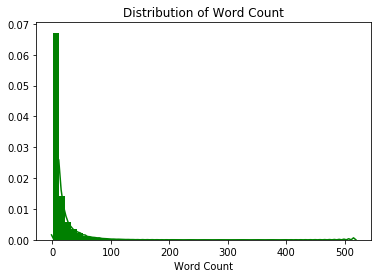

In [6]:
#word count distribution plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(corpus2['wordcount'], color='green', hist_kws=dict(alpha=1))
plt.xlabel('Word Count')
plt.title('Distribution of Word Count')
plt.show()

In [7]:
#from visual inspection, VADER scores seemed crappy with excess words. i included all the data here but it's worth 
#considering cutting them off at some point
#corpus2a = corpus2[corpus2['wordcount'] < 50]

In [9]:
###integrating vader
###come back here and take it out if it doesn't pan out
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
corpus2a = corpus2.transcript.apply(analyzer.polarity_scores)

In [10]:
#appending vader scores to the main data frame 
from collections import defaultdict
tmp = defaultdict(list)
for i,row in corpus2a.iteritems():
    for k in row:
        tmp[k].append(row[k])
        
tmp = pd.DataFrame(tmp)
corpus2b = pd.concat([corpus2, tmp], axis=1)

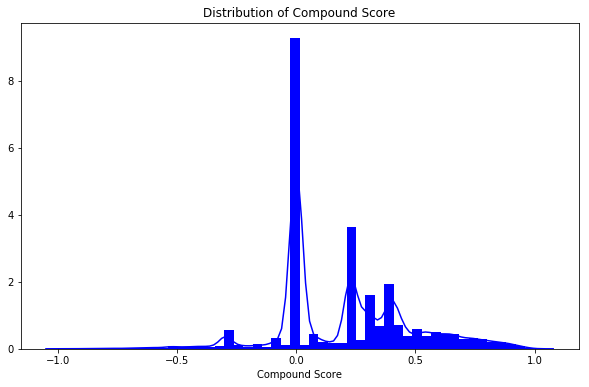

In [11]:
#compound score distribution 
#it is typically for these to have a left skew
#models tend to be better at identifying positive sentiment relative to negative
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(corpus2b['compound'], color='blue', hist_kws=dict(alpha=1))
plt.xlabel('Compound Score')
plt.title('Distribution of Compound Score')
plt.show()

In [12]:
corpus2b.head()

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount,transcript_strip,speaker_cat,neg,neu,pos,compound
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12,those recovery minutes name you thomas speakin...,Agent,0.0,0.787,0.213,0.4019
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20,hi angela this is katie the phone number one e...,Borrower,0.0,0.933,0.067,0.0772
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3,four worth okay,Agent,0.0,0.208,0.792,0.4215
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1,alright,Borrower,0.0,0.000,1.000,0.2500
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7,this it's i you get submit okay,Borrower,0.0,0.725,0.275,0.2263


In [13]:
#from the plot it appears that a majority are neutral
corpus2c = corpus2b[corpus2b['compound'] != 0]
corpus2c.head()
corpus2c.shape

(119502, 16)

In [14]:
#68508 cases have a compound score of 0... let's disregard them. all code after this it the original
#pre-integration of vader scores
corpus2b.shape

(188010, 16)

In [15]:
#focusing just on the two columns of interest - transcript_strip and emotion
#getting rid of all null values
from io import StringIO

col = ['transcript_strip', 'emotion']
corpus3 = corpus2c[col]
corpus3 = corpus3[pd.notnull(corpus3['transcript_strip'])]
corpus3 = corpus3[pd.notnull(corpus3['emotion'])]


corpus3.columns = ['transcript_strip', 'emotion']

corpus3['category_id'] = corpus3['emotion'].factorize()[0]
category_id_corpus3 = corpus3[['emotion', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_corpus3.values)
id_to_category = dict(category_id_corpus3[['category_id', 'emotion']].values)

corpus3.head()

,transcript_strip,emotion,category_id
282,alright thank you,polite,0
425,i could do it as perfect if you could split it up,no emotion,1
599,alright thanks,polite,0
981,alright thank you so much for holding this is ...,polite,0
1956,alright thank you so much,polite,0


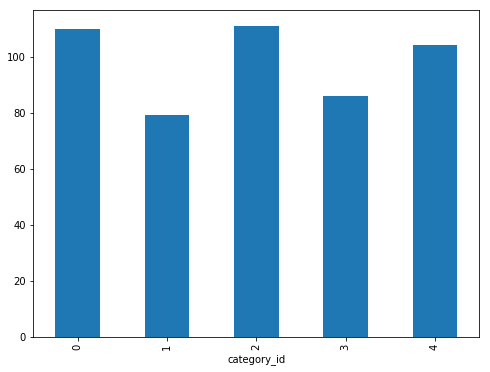

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
corpus3.groupby('category_id').transcript_strip.count().plot.bar(ylim=0)
plt.show()

In [17]:
#now each of the transcript narratives is represented by features representing the tf-idf score for different unigram and bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(corpus3.transcript_strip).toarray()
labels = corpus3.category_id
features.shape

(490, 228)

In [18]:
#find the terms more correlated w each of the emotion labels
#just curious
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for emotion, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(emotion))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'angry':
  . Most correlated unigrams:
. harassing
. law
  . Most correlated bigrams:
. broke law
. just broke
# 'avoidant':
  . Most correlated unigrams:
. pay
. money
  . Most correlated bigrams:
. money right
. don money
# 'confused':
  . Most correlated unigrams:
. sorry
. confused
  . Most correlated bigrams:
. don know
. little confused
# 'no emotion':
  . Most correlated unigrams:
. yes
. okay
  . Most correlated bigrams:
. just calling
. alright thank
# 'polite':
  . Most correlated unigrams:
. alright
. thank
  . Most correlated bigrams:
. alright thanks
. alright thank


In [19]:
#fitting multinomial naive bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(corpus3['transcript_strip'], corpus3['emotion'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [20]:
#this allows me to test out how classification is going
print(clf.predict(count_vect.transform(["i'm not going to pay"])))

['avoidant']


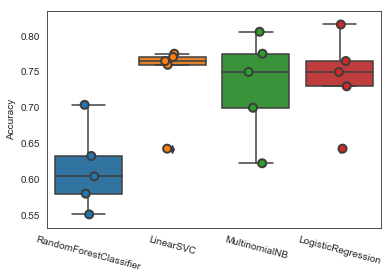

In [21]:
#bench marking 4 models - logistic regression, multinomial naive bayes, linear support vector machine, random forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

sns.set_style("white")

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

mod_plot = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
mod_plot = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.setp(mod_plot.get_xticklabels(), rotation=345)
mod_plot.set(xlabel='', ylabel='Accuracy')



plt.show()

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.742901
LogisticRegression        0.740898
MultinomialNB             0.730816
RandomForestClassifier    0.614384
Name: accuracy, dtype: float64

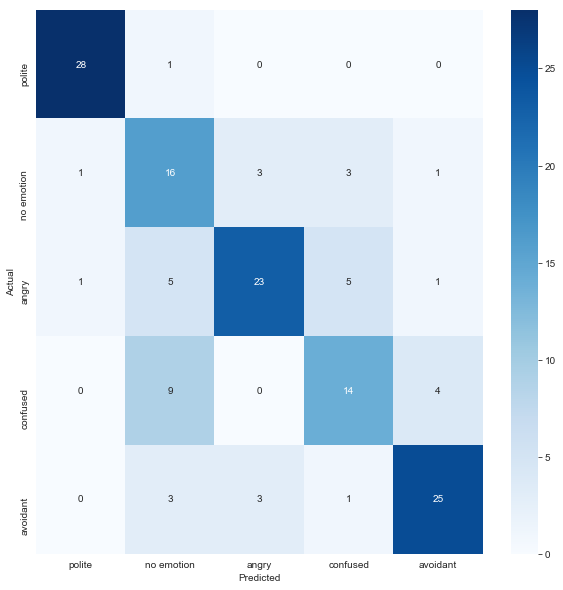

In [23]:
#confusion matrix - raw numbers 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus3.index, test_size=0.30, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=category_id_corpus3.emotion.values, yticklabels=category_id_corpus3.emotion.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

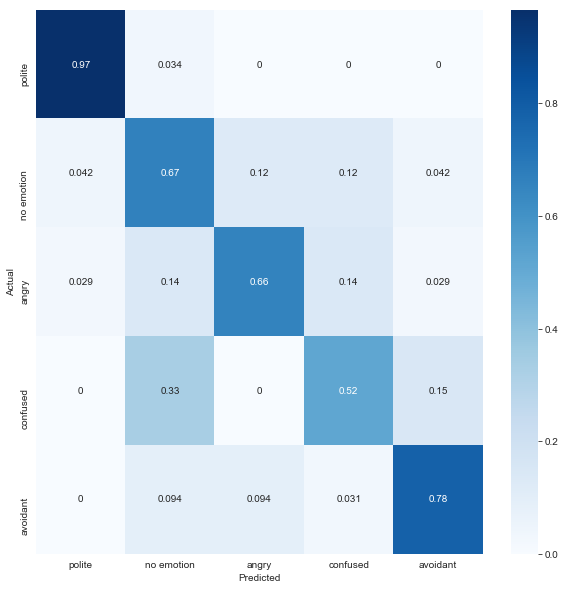

In [24]:
#confusion matrix - normalized
conf_mat = confusion_matrix(y_test, y_pred)
cm_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, cmap="Blues",
            xticklabels=category_id_corpus3.emotion.values, yticklabels=category_id_corpus3.emotion.values)
sns.set(font_scale=1.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_corpus3.category_id:
  for actual in category_id_corpus3.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 5:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(corpus3.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['emotion', 'transcript_strip']])
      print('')

In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=corpus3['emotion'].unique()))

In [ ]:
#save model after training
import joblib
joblib.dump(model, 'model.pkl')

In [ ]:
#When you need to load it:
#model = open('model.pkl','rb')
#model = joblib.load(model)

In [ ]:
result = model.score(X_test, y_test)

In [ ]:
print(result)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
print(y_pred)

In [ ]:
#for untested data we want borrowers only, emotion column empty, and compound score != 0
#already have no compound scores of 0 from above code
corpus_subset = corpus2c[(corpus2c.speaker_cat == 'Borrower')]
corpus_subset.head()

In [ ]:
#focusing just on the one columns of interest - transcript_strip and emotion
#getting rid of all null values
from io import StringIO

col_new = ['transcript_strip']
corpus_new = corpus_subset[col_new]
corpus_new = corpus_new[pd.notnull(corpus_new['transcript_strip'])]

corpus_new.columns = ['transcript_strip']
corpus_new.head()

In [ ]:
test_features = tfidf.transform(corpus_subset.transcript_strip)

In [ ]:
X_new = (test_features)

In [ ]:
y_new = model.predict(test_features)

In [ ]:
print(y_new)

In [ ]:
y_new.shape

In [ ]:
y_new_df = pd.DataFrame(y_new)
y_new_df.head()

In [ ]:
#integrating categorizations back in 
corpus_run = pd.concat([corpus_subset.reset_index(drop=True), y_new_df], axis=1)
corpus_run.head()